In [ ]:
df_reg = df.dropna(subset=['ecommerce', 'Internet_Penetration', 'GDP_per_Capita',
                          'EGDI', 'Digitalmarketing', 'Users_social',
                          'Users_social_per', 'Telecommunications_computer_and_information_services'])

print(f"Данные для регрессии: {df_reg.shape[0]} наблюдений из {df.shape[0]} исходных")

Данные для регрессии: 1171 наблюдений из 1172 исходных


In [ ]:
# Метод наименьших квадратов (OLS)
formula = 'ecommerce ~ Internet_Penetration + GDP_per_Capita + EGDI + Digitalmarketing + Users_social + Users_social_per + Telecommunications_computer_and_information_services'

model = smf.ols(formula=formula, data=df_reg).fit()

In [ ]:
# Регрессионный анализ
def format_stata_results(model):
    """
    Форматирует результаты регрессии в стиле Stata с 90% доверительными интервалами
    """
    # Получаем коэффициенты и стандартные ошибки
    params = model.params
    bse = model.bse
    tvalues = model.tvalues
    pvalues = model.pvalues

    # Вычисляем 90% доверительные интервалы (alpha=0.10)
    conf_int = model.conf_int(alpha=0.10)
    conf_int.columns = ['0.05', '0.95']  # Переименовываем столбцы в соответствии с 90% ДИ

    # Создаем DataFrame с результатами
    results = pd.DataFrame({
        'Coefficient': params,
        'Std. Error': bse,
        't-value': tvalues,
        'P>|t|': pvalues,
        '0.05': conf_int['0.05'],
        '0.95': conf_int['0.95']
    })

    # Добавляем столбец со звездочками для значимости
    stars = []
    for pval in results['P>|t|']:
        if pval < 0.001:
            stars.append('***')
        elif pval < 0.01:
            stars.append('**')
        elif pval < 0.05:
            stars.append('*')
        else:
            stars.append('')

    results[''] = stars  # Пустой заголовок для звездочек

    # Округление значений
    results['Coefficient'] = results['Coefficient'].round(10)
    results['Std. Error'] = results['Std. Error'].round(10)
    results['t-value'] = results['t-value'].round(10)
    results['P>|t|'] = results['P>|t|'].round(10)
    results['0.05'] = results['0.05'].round(10)
    results['0.95'] = results['0.95'].round(10)

    return results

# Результаты
stata_results = format_stata_results(model)
display(HTML("<h3>Регрессионный анализ (OLS) </h3>"))
display(stata_results)

,Coefficient,Std. Error,t-value,P>|t|,0.05,0.95,
Intercept,-83.717175,18.090526,-4.627681,0.000004,-113.497164,-53.937187,***
Internet_Penetration,31.871497,16.310404,1.954059,0.050934,5.021883,58.721111,
GDP_per_Capita,-0.000047,0.000078,-0.603792,0.546100,-0.000175,0.000081,
EGDI,-26.003569,21.692525,-1.198734,0.230876,-61.713041,9.705903,
Digitalmarketing,4.444681,0.135915,32.701937,0.000000,4.220943,4.668419,***
Users_social,2085.479948,24.492503,85.147686,0.000000,2045.161250,2125.798646,***
Users_social_per,81.334507,27.237605,2.986111,0.002885,36.496919,126.172096,**
Telecommunications_computer_and_information_services,0.273397,0.108745,2.514099,0.012068,0.094384,0.452410,*


In [ ]:
# Добавляем стандартную таблицу ANOVA в формате Stata
def format_stata_anova(model):
    """
    Форматирует ANOVA таблицу в стиле Stata
    """
    # Извлекаем необходимые статистики из модели
    nobs = int(model.nobs)
    df_model = int(model.df_model)
    df_resid = int(model.df_resid)
    df_total = df_model + df_resid

    ss_model = model.ess  # Sum of Squares Model
    ss_resid = model.ssr  # Sum of Squares Residual
    ss_total = ss_model + ss_resid

    ms_model = ss_model / df_model if df_model > 0 else 0
    ms_resid = ss_resid / df_resid if df_resid > 0 else 0

    f_value = model.fvalue
    f_pvalue = model.f_pvalue
    r_squared = model.rsquared
    adj_r_squared = model.rsquared_adj
    root_mse = np.sqrt(model.mse_resid)

    # Создаем форматированную таблицу
    anova_data = {
        'Source': ['Model', 'Residual', 'Total'],
        'SS': [ss_model, ss_resid, ss_total],
        'df': [df_model, df_resid, df_total],
        'MS': [ms_model, ms_resid, '']
    }

    anova_df = pd.DataFrame(anova_data)

    # Форматируем числа
    anova_df['SS'] = anova_df['SS'].apply(lambda x: f"{x:,.2f}")
    anova_df['MS'] = anova_df['MS'].apply(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else '')

    # Создаем строку с дополнительной информацией
    info_lines = [
        f"Number of obs = {nobs}",
        f"F({df_model}, {df_resid}) = {f_value:.2f}",
        f"Prob > F = {f_pvalue:.4f}",
        f"R-squared = {r_squared:.4f}",
        f"Adj R-squared = {adj_r_squared:.4f}",
        f"Root MSE = {root_mse:.2f}"
    ]

    # Форматируем вывод в стиле Stata
    stata_output = f"""
Source |       SS           df       MS      {info_lines[0]}
-------------+----------------------------------   {info_lines[1]}
       Model |  {anova_df.iloc[0]['SS']:>12}  {anova_df.iloc[0]['df']:>6}  {anova_df.iloc[0]['MS']:>11}   {info_lines[2]}
    Residual |  {anova_df.iloc[1]['SS']:>12}  {anova_df.iloc[1]['df']:>6}  {anova_df.iloc[1]['MS']:>11}   {info_lines[3]}
-------------+----------------------------------   {info_lines[4]}
       Total |  {anova_df.iloc[2]['SS']:>12}  {anova_df.iloc[2]['df']:>6}              {info_lines[5]}
    """

    return stata_output

# Отображаем ANOVA таблицу в формате Stata
stata_anova = format_stata_anova(model)
print(stata_anova)


Source |       SS           df       MS      Number of obs = 1171
-------------+----------------------------------   F(7, 1163) = 1879.25
       Model |  69,210,256.66       7  9,887,179.52   Prob > F = 0.0000
    Residual |  6,118,833.15    1163     5,261.25   R-squared = 0.9188
-------------+----------------------------------   Adj R-squared = 0.9183
       Total |  75,329,089.81    1170              Root MSE = 72.53
    


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display, HTML
import warnings; warnings.filterwarnings("ignore")

# Загрузка данных
df = pd.read_csv(r"C:\Users\andreyb\Desktop\обработанные_данные.csv")

# Выбор переменных для корреляционного анализа
corr_vars = ['ecommerce', 'Internet_Penetration', 'GDP_per_Capita', 'EGDI',
             'Digitalmarketing', 'Users_social', 'Users_social_per',
             'Telecommunications_computer_and_information_services']

# Удаляем пропуски для анализа
df_corr = df[corr_vars].dropna()

# Функция для форматирования корреляций со звездочками как в Stata
def format_stata_correlations(df, variables, star_levels=(0.05, 0.01, 0.001), decimals=3):
    """
    Рассчитывает корреляционную матрицу в формате Stata со звездочками для уровней значимости

    Parameters:
    -----------
    df : pandas DataFrame
        Данные для анализа
    variables : list
        Список переменных для корреляционного анализа
    star_levels : tuple
        Уровни значимости для звездочек (p<0.05, p<0.01, p<0.001)
    decimals : int
        Количество знаков после запятой для корреляций

    Returns:
    --------
    pandas DataFrame
        Форматированная корреляционная матрица со звездочками
    """

    # Создаем пустые матрицы для корреляций и p-значений
    corr_matrix = pd.DataFrame(index=variables, columns=variables)
    p_matrix = pd.DataFrame(index=variables, columns=variables)

    # Рассчитываем корреляции и p-значения для каждой пары переменных
    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            if i <= j:  # Заполняем только верхний треугольник (включая диагональ)
                if var1 == var2:
                    # Диагональ - корреляция с самим собой = 1.0
                    corr_matrix.loc[var1, var2] = 1.0
                    p_matrix.loc[var1, var2] = 0.0
                else:
                    # Рассчитываем корреляцию Пирсона и p-значение
                    corr, p_value = stats.pearsonr(df[var1], df[var2])
                    corr_matrix.loc[var1, var2] = corr
                    p_matrix.loc[var1, var2] = p_value

    # Создаем форматированную матрицу со звездочками
    formatted_matrix = pd.DataFrame(index=variables, columns=variables)

    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            if i <= j:  # Верхний треугольник
                corr_val = corr_matrix.loc[var1, var2]
                p_val = p_matrix.loc[var1, var2]

                # Форматируем корреляцию с правильным количеством знаков
                corr_str = f"{corr_val:.{decimals}f}"

                # Добавляем звездочки в зависимости от уровня значимости
                if p_val < star_levels[2]:  # p < 0.001
                    corr_str += "***"
                elif p_val < star_levels[1]:  # p < 0.01
                    corr_str += "**"
                elif p_val < star_levels[0]:  # p < 0.05
                    corr_str += "*"

                formatted_matrix.loc[var1, var2] = corr_str

    # Заполняем нижний треугольник пустыми значениями для симметрии
    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            if i > j:
                formatted_matrix.loc[var1, var2] = ""

    return formatted_matrix

# Функция для создания красивого вывода как в Stata
def display_stata_correlation(df, variables, title="Correlation matrix"):
    """
    Отображает корреляционную матрицу в формате Stata

    Parameters:
    -----------
    df : pandas DataFrame
        Данные для анализа
    variables : list
        Список переменных
    title : str
        Заголовок таблицы
    """

    # Форматируем корреляционную матрицу
    corr_table = format_stata_correlations(df, variables)

    # Добавляем подвал с пояснением звездочек
    footnote = """
    * p < 0.05, ** p < 0.01, *** p < 0.001
    """

    # Создаем HTML для красивого вывода
    html_content = f"""
    <div style="font-family: monospace; font-size: 14px; line-height: 1.4;">
        <h3>{title}</h3>
        <table border="1" style="border-collapse: collapse; margin: 10px 0;">
            <tr>
                <th style="padding: 8px; text-align: left; background-color: #f2f2f2;">Variable</th>
    """

    # Заголовки столбцов
    for var in variables:
        html_content += f'<th style="padding: 8px; text-align: center; background-color: #f2f2f2;">{var}</th>'

    html_content += "</tr>"

    # Строки данных
    for i, var in enumerate(variables):
        html_content += f'<tr><td style="padding: 8px; font-weight: bold;">{var}</td>'
        for j, col_var in enumerate(variables):
            value = corr_table.loc[var, col_var]
            # Выделяем значимые корреляции жирным шрифтом
            if isinstance(value, str) and ('*' in value):
                style = "font-weight: bold;"
            else:
                style = ""
            html_content += f'<td style="padding: 8px; text-align: center; {style}">{value}</td>'
        html_content += "</tr>"

    html_content += f"""
        </table>
        <p style="font-style: italic; color: #666; margin-top: 10px;">{footnote}</p>
        <p style="color: #666;">Observations: {len(df.dropna(subset=variables))}</p>
    </div>
    """

    display(HTML(html_content))

# Выполнение корреляционного анализа
display_stata_correlation(df_corr, corr_vars, title="Correlation matrix (Pearson)")

# Дополнительно: создаем компактную версию как в Stata для вывода в консоль
def print_stata_style_correlation(df, variables):
    """
    Печатает корреляционную матрицу в компактном формате Stata
    """
    corr_table = format_stata_correlations(df, variables)

    print("\n" + "="*80)
    print("CORRELATION MATRIX (Pearson)")
    print("="*80)
    print(f"{'Variable':<30}", end="")
    for var in variables:
        print(f"{var:<15}", end="")
    print()
    print("-"*80)

    for i, var in enumerate(variables):
        print(f"{var:<30}", end="")
        for j, col_var in enumerate(variables):
            if i <= j:
                value = corr_table.loc[var, col_var]
                print(f"{value:<15}", end="")
            else:
                print(f"{'':<15}", end="")
        print()

    print("-"*80)
    print(f"Observations: {len(df.dropna(subset=variables))}")
    print("* p < 0.05, ** p < 0.01, *** p < 0.001")

# Компактный вывод в консоль
print_stata_style_correlation(df_corr, corr_vars)

Variable,ecommerce,Internet_Penetration,GDP_per_Capita,EGDI,Digitalmarketing,Users_social,Users_social_per,Telecommunications_computer_and_information_services
ecommerce,1.000***,0.034,0.005,0.050,0.614***,0.899***,0.014,0.450***
Internet_Penetration,,1.000***,0.468***,0.454***,0.100***,-0.045,0.517***,0.233***
GDP_per_Capita,,,1.000***,0.283***,0.123***,-0.066*,0.217***,0.299***
EGDI,,,,1.000***,0.032,0.035,0.299***,0.211***
Digitalmarketing,,,,,1.000***,0.339***,0.018,0.535***
Users_social,,,,,,1.000***,-0.039,0.310***
Users_social_per,,,,,,,1.000***,0.092**
Telecommunications_computer_and_information_services,,,,,,,,1.000***



CORRELATION MATRIX (Pearson)
Variable                      ecommerce      Internet_PenetrationGDP_per_Capita EGDI           DigitalmarketingUsers_social   Users_social_perTelecommunications_computer_and_information_services
--------------------------------------------------------------------------------
ecommerce                     1.000***       0.034          0.005          0.050          0.614***       0.899***       0.014          0.450***       
Internet_Penetration                         1.000***       0.468***       0.454***       0.100***       -0.045         0.517***       0.233***       
GDP_per_Capita                                              1.000***       0.283***       0.123***       -0.066*        0.217***       0.299***       
EGDI                                                                       1.000***       0.032          0.035          0.299***       0.211***       
Digitalmarketing                                                                          

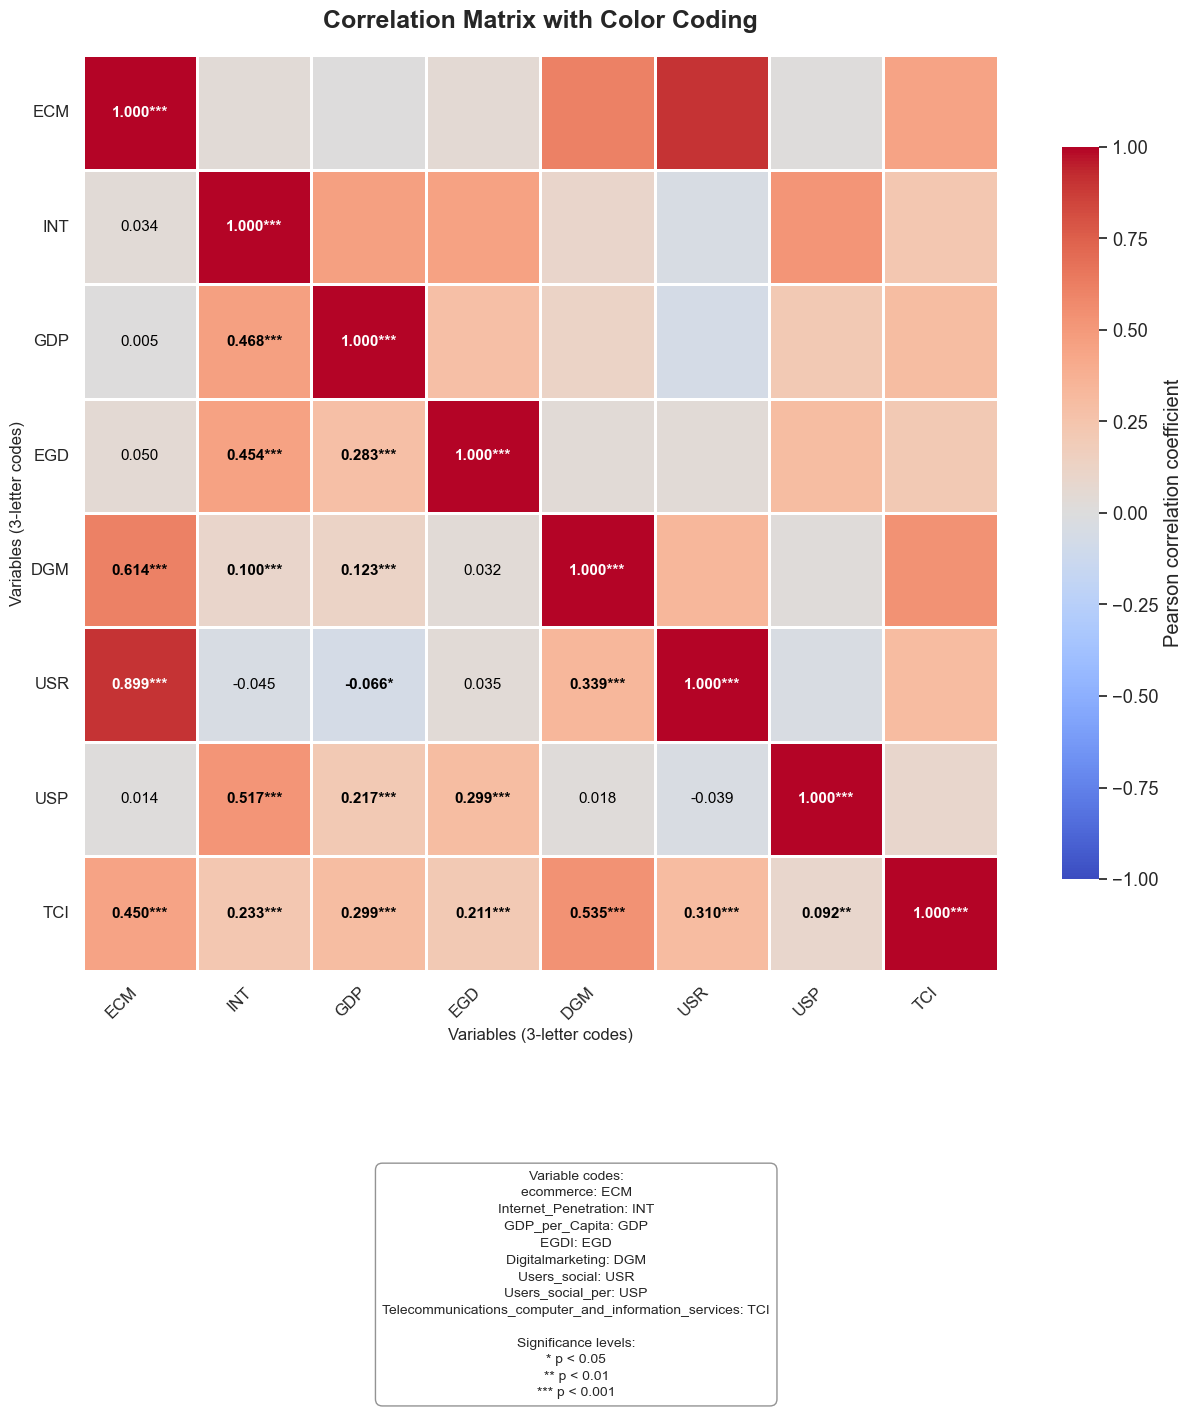

Number of observations for analysis: 1171

Variable codes used in the heatmap:
ecommerce: ECM
Internet_Penetration: INT
GDP_per_Capita: GDP
EGDI: EGD
Digitalmarketing: DGM
Users_social: USR
Users_social_per: USP
Telecommunications_computer_and_information_services: TCI


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings("ignore")

# Загрузка данных
df = pd.read_csv(r"C:\Users\andreyb\Desktop\обработанные_данные.csv")

# Выбор переменных для корреляционного анализа
corr_vars = ['ecommerce', 'Internet_Penetration', 'GDP_per_Capita', 'EGDI',
             'Digitalmarketing', 'Users_social', 'Users_social_per',
             'Telecommunications_computer_and_information_services']

# Создаем словарь сокращений для переменных
short_names = {
    'ecommerce': 'ECM',
    'Internet_Penetration': 'INT',
    'GDP_per_Capita': 'GDP',
    'EGDI': 'EGD',
    'Digitalmarketing': 'DGM',
    'Users_social': 'USR',
    'Users_social_per': 'USP',
    'Telecommunications_computer_and_information_services': 'TCI'
}

# Заменяем названия переменных на короткие версии
short_vars = [short_names[var] for var in corr_vars]

# Удаляем пропуски для анализа
df_corr = df[corr_vars].dropna()

# Рассчитываем корреляционную матрицу Пирсона
correlation_matrix = df_corr[corr_vars].corr(method='pearson')

# Рассчитываем p-значения для каждой корреляции
p_values = pd.DataFrame(np.zeros((len(corr_vars), len(corr_vars))),
                        index=short_vars, columns=short_vars)

for i, var1 in enumerate(corr_vars):
    for j, var2 in enumerate(corr_vars):
        if i != j:
            _, p_val = stats.pearsonr(df_corr[var1], df_corr[var2])
            p_values.iloc[i, j] = p_val
        else:
            p_values.iloc[i, j] = 0  # Диагональ - p-value = 0

# Создаем матрицу с короткими названиями
correlation_matrix_short = pd.DataFrame(
    correlation_matrix.values,
    index=short_vars,
    columns=short_vars
)

# Настраиваем стиль
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Создаем фигуру
plt.figure(figsize=(14, 12))

# Создаем heatmap БЕЗ аннотаций (annot=False), чтобы избежать наложения
heatmap = sns.heatmap(
    correlation_matrix_short,
    annot=False,  # Отключаем стандартные аннотации
    fmt=".3f",   # Формат чисел (не используется, так как annot=False)
    cmap="coolwarm",  # Цветовая схема: синий-красный
    center=0,    # Центр цветовой шкалы на 0
    square=True,  # Квадратные ячейки
    linewidths=0.8,  # Ширина линий между ячейками
    linecolor='white',  # Цвет линий
    cbar_kws={'label': 'Pearson correlation coefficient', 'shrink': 0.8},  # Настройки цветовой шкалы
    vmin=-1, vmax=1  # Фиксированные пределы для лучшего сравнения
)

# Добавляем аннотации ВРУЧНУЮ для всех ячеек, включая звездочки для значимых корреляций
for i in range(len(short_vars)):
    for j in range(len(short_vars)):
        if i >= j:  # Только нижний треугольник (включая диагональ)
            p_val = p_values.iloc[i, j]
            corr_val = correlation_matrix_short.iloc[i, j]

            # Создаем текст аннотации
            text = f"{corr_val:.3f}"

            # Добавляем звездочки в зависимости от значимости
            stars = ""
            if p_val < 0.001:
                stars = "***"
            elif p_val < 0.01:
                stars = "**"
            elif p_val < 0.05:
                stars = "*"

            # Если есть звездочки, добавляем их к тексту
            if stars:
                text += stars

            # Устанавливаем цвет текста в зависимости от фона
            # Получаем цвет ячейки по координатам
            cell_color = heatmap.collections[0].get_facecolors()[i * len(short_vars) + j]
            brightness = np.mean(cell_color[:3])  # Яркость RGB

            # Выбираем цвет текста для лучшей читаемости
            text_color = "white" if brightness < 0.5 else "black"

            # Устанавливаем жирность для значимых корреляций
            fontweight = 'bold' if stars else 'normal'

            # Добавляем текстовую аннотацию в центр ячейки
            heatmap.text(j + 0.5, i + 0.5, text,
                        ha='center', va='center',
                        color=text_color,
                        fontweight=fontweight,
                        fontsize=11)

# Настройка заголовков и меток
plt.title('Correlation Matrix with Color Coding',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Variables (3-letter codes)', fontsize=12)
plt.ylabel('Variables (3-letter codes)', fontsize=12)

# Поворачиваем метки осей для лучшей читаемости
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Создаем легенду для расшифровки кодов
legend_text = "Variable codes:\n"
for short, full in short_names.items():
    legend_text += f"{short}: {full}\n"

legend_text += "\nSignificance levels:\n* p < 0.05\n** p < 0.01\n*** p < 0.001"

# Добавляем легенду в виде текстового блока
plt.figtext(0.5, -0.15, legend_text, ha='center', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.85, edgecolor='gray', boxstyle='round,pad=0.5'),
            linespacing=1.5)

# Устанавливаем границы для лучшего отображения
plt.tight_layout(rect=[0, 0.15, 1, 1])  # Оставляем место для легенды внизу

# Показываем график
plt.show()

# Дополнительно: сохраняем изображение
plt.savefig('correlation_heatmap_fixed.png', bbox_inches='tight', dpi=300)

print(f"Number of observations for analysis: {len(df_corr)}")
print("\nVariable codes used in the heatmap:")
for short, full in short_names.items():
    print(f"{short}: {full}")